<h2>BMIF201 Lecture 2 in-class problem set instructions</h2>

This worksheet is intended to be completed in assigned groups of 2-3 in class. All members of each group should type their own solutions, but the solutions can be exactly identical. Feel free to ask other groups, the TAs, or the professor for assistance. Your homework for this unit will build upon the work that you do in these worksheets.

<h5>Problem 1</h5>

Fill in the item marked `# TODO` in the `next_generation` function below. Verify that the assertion passes.

In [2]:
import numpy as np

class WrightFisher:
    mu: float # symmetric mutation rate, for every site
    N: int # number of haplotypes is 2N
    s: float # selection coefficient, for every site

    # This is the function that is called when you write: model = WrightFisher(...)
    def __init__(self, mu: float, N: int, s: float):
        self.mu = mu
        self.N = N
        self.s = s

    def next_generation(self, allele_frequencies: np.ndarray) -> np.ndarray:
        """
        :param allele_frequencies: array of allele frequencies in generation n
        :return: array of allele frequencies in generation n+1
        """

        # TODO: Compute the expected allele frequency in the following generation 
        # due to the effect of selection
        expected_frequency = (allele_frequencies * (1 + self.s) /
                              (1 + allele_frequencies * self.s))
        
        assert expected_frequency.shape == allele_frequencies.shape
        assert np.all(expected_frequency >= 0)
        assert np.all(expected_frequency <= 1)

        # Drift + mutation
        num_carriers_before = np.random.binomial(2*self.N, expected_frequency)
        num_a_to_A = np.random.binomial(num_carriers_before, self.mu)
        num_A_to_a = np.random.binomial(2*self.N-num_carriers_before, self.mu)
        num_carriers = num_carriers_before + num_A_to_a - num_a_to_A

        assert num_carriers_before.shape == allele_frequencies.shape
        assert num_carriers.shape == allele_frequencies.shape
        assert np.all(num_carriers >= 0)
        assert np.all(num_carriers <= 2 * self.N)

        return num_carriers / (2 * self.N)

    def until_fixation(self, initial_allele_frequencies: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        :param initial_allele_frequencies: initial state
        :return: final allele frequencies (0/1-valued), time to fixation or loss
        """

        allele_frequencies = initial_allele_frequencies.copy()  # avoids modifying input array
        variants = np.where(allele_frequencies * (1-allele_frequencies) > 0)[0]  # sites not yet fixed or lost
        time_to_fixation_or_loss = np.zeros_like(allele_frequencies, dtype=int)

        generations = 0
        while len(variants) > 0:
            generations += 1
            allele_frequencies[variants] = self.next_generation(allele_frequencies[variants])
            newly_fixed_variants = (allele_frequencies[variants] * (1-allele_frequencies[variants]) == 0)
            time_to_fixation_or_loss[variants[newly_fixed_variants]] = generations
            variants = variants[~newly_fixed_variants]

        assert np.all(allele_frequencies * (1-allele_frequencies) == 0)

        return allele_frequencies, time_to_fixation_or_loss


In [3]:
num_sites = 5
mutation_rate = 1e-1
selection_coefficient = 1e-1
population_size = 100
model = WrightFisher(mutation_rate, population_size, selection_coefficient)
generation_zero_frequency = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) 

np.random.seed(123)
generation_one_frequency = model.next_generation(generation_zero_frequency)
assert np.all(generation_one_frequency == np.array([0.2, 0.315, 0.375, 0.465, 0.545]))

<h5>Problem 2</h5>

Recall that in lecture, we derived that the fixation probability of a beneficial allele with selection coefficient s, beginning at an allele frequency of $1/2N$, is approximately $2s$. Verify that this is approximately true when $1/N << 2s << 1$. Discuss with your partner: what happens when $2s < 1/N$, and why? What happens when $2s>1$, and why? 

In [4]:
num_sites = 10_000
mutation_rate = 0
selection_coefficient_array = [2**x for x in range(-12,2)]
population_size = 100
fixation_probability = [] 
for selection_coefficient in selection_coefficient_array:
    model = WrightFisher(mutation_rate, population_size, selection_coefficient)
    allele_frequency, _ = model.until_fixation(1/2/population_size * np.ones(num_sites))
    fixation_probability.append(np.mean(allele_frequency))

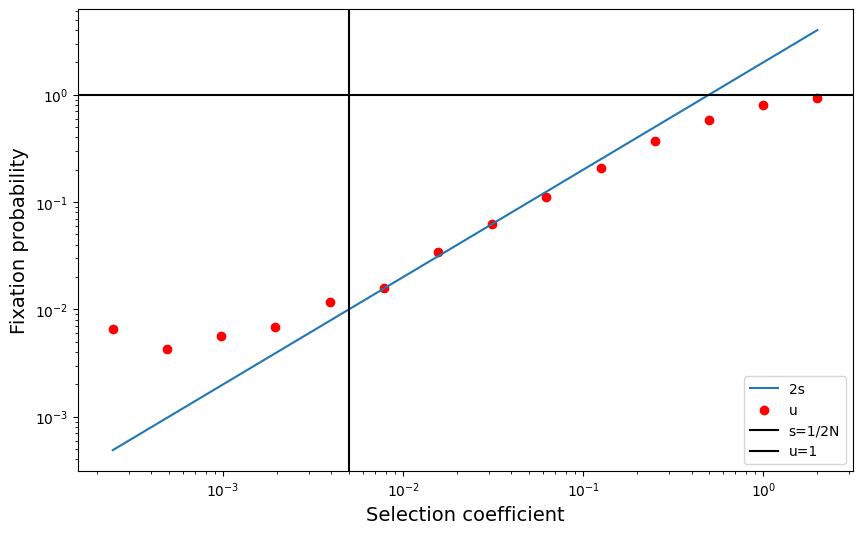

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(selection_coefficient_array, [2 * s for s in selection_coefficient_array])
plt.scatter(selection_coefficient_array, fixation_probability, color='red')
plt.axvline(x = 1 / (2 * population_size), color = 'black', label = '1/2N')
plt.axhline(y = 1, color = 'black', label = '1/2N')

plt.xlabel('Selection coefficient', fontsize=14)
plt.ylabel('Fixation probability', fontsize=14)
plt.legend(["2s", "u", "s=1/2N", "u=1"])
plt.xscale('log')
plt.yscale('log')

plt.show()

<h5>Problem 3</h5>

Recall that $s_{het}$ is the selection coefficient of protein truncating variants (PTVs) in a gene.

Suppose that you have genetic data for a population of $N=50$ individuals. There are $L=100$ sites at which a mutation could create a PTV (possibly, not all of which are observed in your data), each of which has a mutation rate of $\mu=10^{-3}$. All PTVs in the gene have the same selection coefficient, $s_{het}$, which is unknown. Using simulations, you will come up with a test for constraint.

a. Decide with your partner: what is an easily-computed statistic such that you expect it to be different when $s_{het}<<0$ vs. when $s_{het}=0$? (Multiple answers are possible, but I recommend computing something simple; the point is not to come up with something intuitive, not necessarily optimal). 

b. Simulate the null distribution for your statistic, with $s=0$. Plot a histogram of this distribution.

c. Simulate the non-null distribution for your statistic for a few values of $s<0$. For each non-null value of your statistic $X$, let $k_{smaller}$ be the number of null simulations whose statistic was less than or equal to $X$ out of $k_{total}$ in total. Compute the empirical p-value using the following formula:

$$\text{p-value} = \frac{1+k_{smaller}}{1+k_{total}}.$$

Verify that the assertion passes. Discuss this formula with your partner. Why is there a `1` in the numerator and denominator?

d. Plot the median p-value for each value of $s$. Discuss with your partner: what is one factor (besides $s$) that influences the statistical power of your test? What do you expect to happen when you vary it? Vary this factor and test your intuition.


In [6]:
def simulate_gene(model: WrightFisher, num_sites: int) -> np.ndarray:
    """"
    Runs Wright-Fisher for N generations and returns final allele frequencies
    """
    num_generations = model.N
    af = np.ones(num_sites) / population_size
    for _ in range(num_generations):
        af = model.next_generation(af)
    return af

def compute_statistic(allele_frequency: np.ndarray) -> float:
    """
    Computes your test statistic for a single gene

    Hint: this can rely on allele frequency only, and not on
    mutation rates, because mutation rates will be the same in the null
    simulations that you use to get the empirical distribution.
    """
    return np.sum(allele_frequency)

def sample_statistics(model: WrightFisher, num_sites: int, num_genes: int) -> list[float]:
    """
    Samples test statistics under the specified model, which can be either null or non-null
    """
    test_statistics = []
    for _ in range(num_genes):
        allele_frequency = simulate_gene(model, num_sites)
        test_statistics.append(compute_statistic(allele_frequency))
    return test_statistics

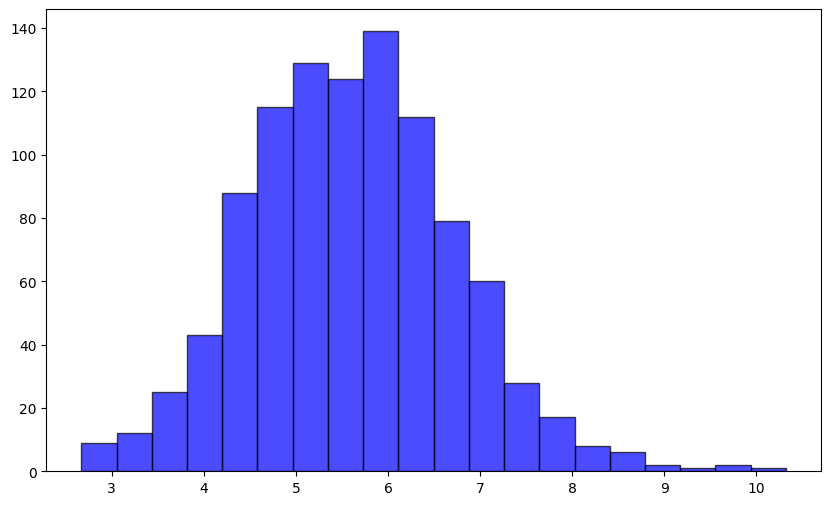

In [ ]:
# Problem 2b

mu = 0.001
N = 50
model = WrightFisher(mu, N, s=0)

num_sites = 100
num_genes = 1000
null_constraint_statistics = sample_statistics(model, num_sites, num_genes)

plt.figure(figsize=(10, 6))
plt.hist(null_constraint_statistics, bins=20, alpha=0.7, color='blue', edgecolor='black')
pass

In [ ]:
# Problem 2c

def empirical_pvalue(null_distribution: np.ndarray, observed_statistic: float) -> float:
    """Computes the p-value for one gene"""
    return (1 + np.sum(null_distribution <= observed_statistic)) / (1 + len(null_distribution))
 
p_values = [empirical_pvalue(np.arange(.01,1,.01), x) for x in np.arange(0,1,.1)]
assert np.allclose(p_values, np.arange(.01, 1, .1))

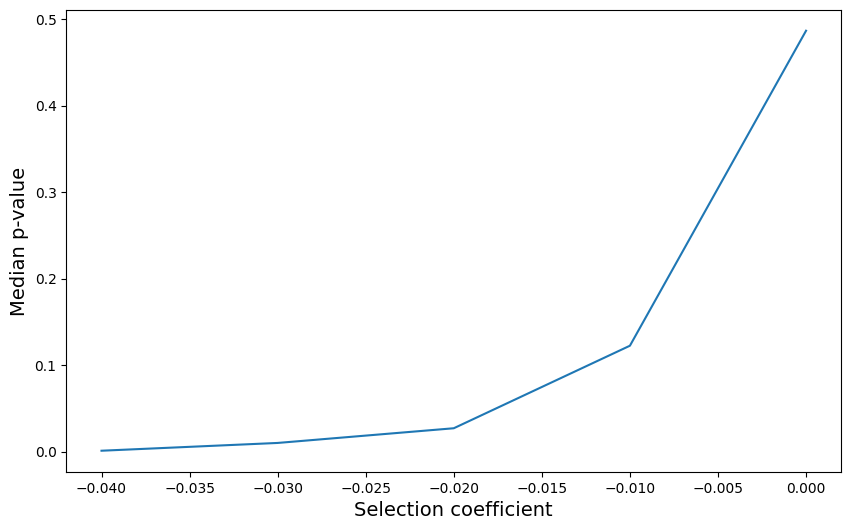

In [ ]:
# Problem 2d

selection_coefficient_array = [-0.01 * i for i in range(5)]

median_pvals = []
num_genes = 100
for s in selection_coefficient_array:
    model = WrightFisher(mu, N, s)
    nonnull_statistics = sample_statistics(model, num_sites, num_genes)
    p_values = [empirical_pvalue(null_constraint_statistics, x) for x in nonnull_statistics]
    median_pvals.append(np.median(p_values))

plt.figure(figsize=(10, 6))
plt.plot(selection_coefficient_array, median_pvals)
plt.xlabel('Selection coefficient', fontsize=14)
plt.ylabel('Median p-value', fontsize=14)
plt.show()

In [ ]:
# Problem 2e
   
selection_coefficient = -.02
num_sites_arr = np.arange(10,210,20)
median_pvals = []
num_genes = 100
for num_sites in num_sites_arr:
    null_model = WrightFisher(mu, N, s=0)
    null_statistics = sample_statistics(null_model, num_sites, num_genes)

    nonnull_model = WrightFisher(mu, N, s=selection_coefficient)
    nonnull_statistics = sample_statistics(nonnull_model, num_sites, num_genes)
    
    p_values = [empirical_pvalue(null_statistics, x) for x in nonnull_statistics]
    median_pvals.append(np.median(p_values))


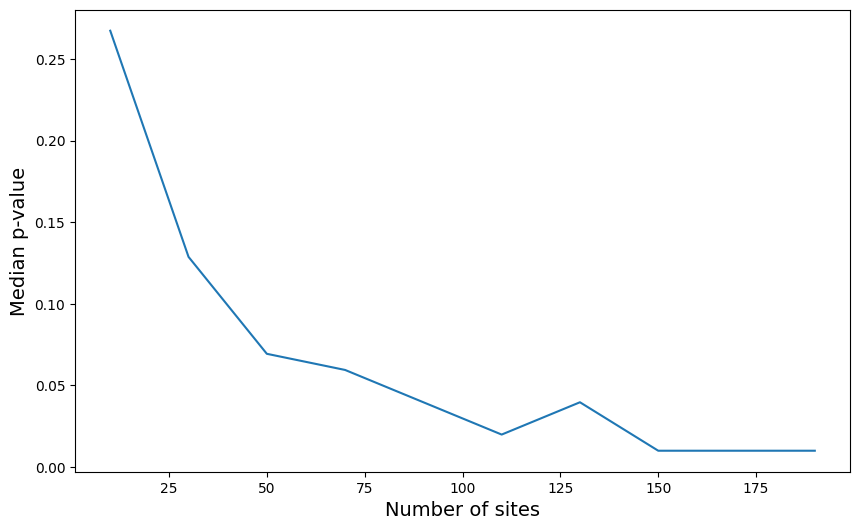

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(num_sites_arr, median_pvals)

plt.xlabel('Number of sites', fontsize=14)
plt.ylabel('Median p-value', fontsize=14)

plt.show()

<h3>Optional problems</h3>

If you finish the problems above early, please work on the following problem with your partner. 

<h5>Problem 3</h5>

We learned in lecture that the fixation time of a beneficial allele is much smaller than that of a neutral allele. Find the average fixation time for a few positive values of $s$. Next, find the fixation time of a deleterious allele having the same absolute selection coefficient: what do you notice? Discuss with your partner and try to get intuition for this phenomenon.

In [18]:
num_sites = 1_000_000
mutation_rate = 0
selection_coefficient_array = [0.005 * i for i in range(-5,6)]
population_size = 100
fixation_time = []
for selection_coefficient in selection_coefficient_array:
    model = WrightFisher(mutation_rate, population_size, selection_coefficient)
    allele_frequency, stopping_time = model.until_fixation(1/2/population_size * np.ones(num_sites))
    fixation_time.append(np.mean(stopping_time[allele_frequency == 1]))
print(fixation_time)

[np.float64(132.0), np.float64(242.41666666666666), np.float64(242.15384615384616), np.float64(316.0551181102362), np.float64(377.0099194048357), np.float64(399.09621578099836), np.float64(375.7679376083189), np.float64(333.67910484791344), np.float64(286.2992789271514), np.float64(249.62149484268906), np.float64(220.01316695532415)]


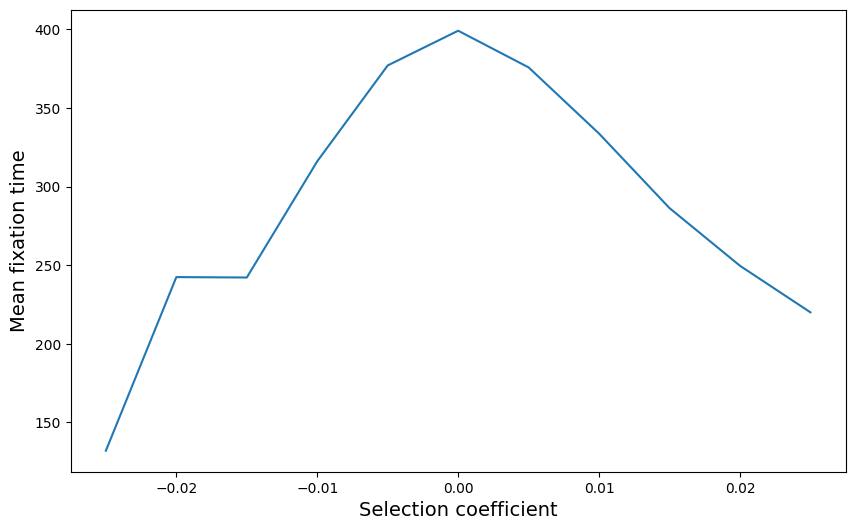

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(selection_coefficient_array, fixation_time)
plt.xlabel('Selection coefficient', fontsize=14)
plt.ylabel('Mean fixation time', fontsize=14)
plt.show()